In [63]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [64]:
FIRST_SIZE = 2
LAST_SIZE = 16

COUNT_TRIES = 10

MAX_DEF_COUNT_ITER = 100000
"""Максимальное количество итераций по-умолчанию"""
DEF_EPS = 0.0001
"""Точность по-умолчанию"""

'Точность по-умолчанию'

In [65]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time",
        "value_min_rel",
        "value_min_rel_time"
    ],
    index=range(1, (LAST_SIZE - FIRST_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Подготовка

In [66]:
def calc(A: np.matrix, b: np.matrix) -> np.matrix:
    if b is None:
        print("Вектор собственного значения не был посчитан")
        return None
    return float((b.T @ A @ b) / (b.T @ b))

# Прямой метод

$x^{(k)} = \dfrac{Ax^{(k - 1)}}{\alpha_{k - 1}}$

$\lambda_{1}(A) = \dfrac{\left( Ax^{(k)}, x^{(k)} \right)}{(x^{(k)}, x^{(k)})} = \dfrac{(x^{(k)})^{T}A^{(k)}x^{(k)}}{(x^{(k)})^{T}x^{(k)}}$, где $|\lambda_1(A)|$ - наибольшее по модулю СЗ

In [67]:
def power_iteration(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1)
    # print("Начальное приближение:", b_k, sep="\n")

    alpha_old = None

    # for _ in range(num_iterations):
    while True:
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)

        b_k = b_k1 / b_k1_norm

        alpha_new = calc(A, b_k)
        if alpha_old is not None and abs(alpha_new - alpha_old) < epsilon:
            break
        alpha_old = alpha_new

    return b_k, alpha_new

# Обратный метод

## Стандартная версия

In [68]:
def inverse_power_def(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    try:
        inv_A = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None
    # print("Обратная матрица:",inv_A, sep="\n")
    res = power_iteration(
        A = inv_A, epsilon=epsilon, num_iterations=num_iterations, b_k=b_k
    )
    return res[0], 1 / res[1]

In [69]:
# A: np.matrix = np.matrix("1 3 -2 0;"
#                          "1 1 4 7;"
#                          "4 7 11 23;"
#                          "52 66 2 0")  # -0.65
# calc(A, inverse_power_def(A))

## Модификация Релэя

In [70]:
import random


def inverse_power_rel(
    A, epsilon: float = DEF_EPS, num_iterations=MAX_DEF_COUNT_ITER, mu=None, b_k=None
):
    if b_k is None:
        b_k = np.random.rand(
            A.shape[1], 1
        )  # Попробовать близкий к настоящему собственный вектор
    if mu is None:
        mu = random.randint(1, 10)  # Случайное начальное приближение
    #   print("Начальное приближение:", "СЗ:", mu, "СВ:", b_k, sep="\n")

    b_k = b_k / np.linalg.norm(b_k)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    # print(lambda_, lambda_ * x)
    mu = mu + 1 / lambda_
    #   mu = calc(A, b_k)
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

    index = 0
    while err > epsilon and index < num_iterations:
        b_k = y / np.linalg.norm(y)
        y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
        lambda_ = float(np.dot(y.T, b_k))
        mu = mu + 1 / lambda_
        err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)
        index += 1

    return b_k, float(mu)

In [71]:
def inverse_power_rel(A, epsilon = DEF_EPS, mu = None, b_k = None):
  if b_k is None:
      b_k = np.random.rand(A.shape[1], 1) # Попробовать близкий к настоящему собственный вектор
  if mu is None:
    mu = random.randint(1, 1000) / 100
#   print("R:\n", mu, " ", b_k, "\n")
  
  b_k = b_k / np.linalg.norm(b_k)
  y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
  # print(y)
  # print(x)
  lambda_ = float(np.dot(y.T, b_k))
  # print(lambda_, lambda_ * x)
  mu = mu + 1 / lambda_
  err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  while err > epsilon:
    b_k = y / np.linalg.norm(y)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    mu = mu + 1 / lambda_
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  return b_k, float(mu)

In [72]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# Сильно зависит от начального приближения
# Не вижу в ней смысла
inverse_power_rel(A)[1]
# calc(A, inverse_power_rel(A)[0])

1.0481797300052189e-14

## Модификация Арнольди

In [73]:
def arnoldi_iteration(A, n: int, epsilon: float = DEF_EPS, b_k=None):
    """Compute a basis of the (n + 1)-Krylov subspace of the matrix A.

    This is the space spanned by the vectors {b, Ab, ..., A^n b}.

    Parameters
    ----------
    A : array_like
        An m times m array.
    b_k : array_like
        Initial vector (length m).
    n : int
        One less than the dimension of the Krylov subspace, or equivalently the *degree* of the Krylov space. Must be >= 1.

    Returns
    -------
    Q : numpy.array
        An m x (n + 1) array, where the columns are an orthonormal basis of the Krylov subspace.
    h : numpy.array
        An (n + 1) x n array. A on basis Q. It is upper Hessenberg.
    """
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1).ravel()
    eps = epsilon
    h = np.zeros((n + 1, n))
    Q = np.zeros((A.shape[0], n + 1))
    # Normalize the input vector
    Q[:, 0] = b_k / np.linalg.norm(b_k, 2)  # Use it as the first Krylov vector
    for k in range(1, n + 1):
        v = np.dot(A, Q[:, k - 1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j, k - 1] = np.dot(Q[:, j].conj(), v)
            v = v - h[j, k - 1] * Q[:, j]
        h[k, k - 1] = np.linalg.norm(v, 2)
        if h[k, k - 1] > eps:  # Add the produced vector to the list, unless
            Q[:, k] = v / h[k, k - 1]
        else:  # If that happens, stop iterating.
            return Q, h
    return Q, h

In [74]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# arnoldi_iteration(A=A, n=3)

# Вычисление

In [75]:
def output(
    A: np.matrix,
    texts: list[str],
    funcs: list,

    num_iterrations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    mu: float = None,
) -> tuple[np.matrix, list[float | None]]:
    
    eigs = np.linalg.eigvals(A)
    if not isinstance(any(np.linalg.eigvals(A)), float):
        print(eigs)

    abs_v = np.abs(np.linalg.eigvals(A))

    abs_v_max = np.max(abs_v)

    abs_v_min = np.min(abs_v)
    # print(

    #     "Собственные значения матрицы A",

    #     f"Максимальное: {abs_v_max}",
    #     f"Минимальное: {abs_v_min}",
    #     sep="\n",
    # )


    # print("========")

    mass_eval = []


    for text, f in zip(texts, funcs):
        start_time = time()
        # print(text)
        if f.__name__ != inverse_power_rel.__name__:
            evec, eval = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # evec = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # eval = calc(A, evec)
        else:
            evec, eval = f(A=A, b_k=b_k, mu=mu)
        stop_time = time()
        # print("========")
        mass_eval.append(abs(eval))
        mass_eval.append(stop_time - start_time)


    # print(text_1)

    # first_evec = f_1(A=A, num_iterations=num_iterrations, b_k=b_k)

    # first_eval = calc(A, first_evec)
    # print("========")


    # print(text_2)

    # if f_2.__name__ != inverse_power_rel.__name__:

    #     second_evec = f_2(A=A, num_iterations=num_iterrations, b_k=b_k)

    #     second_eval = calc(A, second_evec)

    # else:

    #     second_evec, second_eval = f_2(A=A, b_k=b_k, mu=mu)
    # print("========")

    # print(


    #     "Собственные векторы:",

    #     f"{text_1}:",
    #     first_evec,


    #     f"{text_2}:",

    #     second_evec,

    #     sep="\n",
    # )
    # print(


    #     "Собственные значения:",

    #     f"{text_1}: {first_eval}",

    #     f"{text_2}: {second_eval}",

    #     sep="\n",
    # )


    return A.shape[0], abs_v_max, abs_v_min, *mass_eval

In [76]:
def generate_non_singular(n):
    while True:
        # Генерируем случайную матрицу n x n
        matrix = np.random.rand(n, n)  # Вы можете использовать np.random.randint для целых чисел.
        if np.linalg.det(matrix) != 0:  # Проверяем, что определитель не равен нулю
            return matrix

: 

In [77]:
import numpy as np
# texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Арнольди)"]
# funcs = [power_iteration, inverse_power_def, arnoldi_iteration]
texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Релэя)"]
funcs = [power_iteration, inverse_power_def, inverse_power_rel]
# texts = ["Прямые итерации", "Обратные итерации (обычные)"]
# funcs = [power_iteration, inverse_power_def]
mass = []

for i in range(FIRST_SIZE, LAST_SIZE + 1):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        # matr = matr @ matr.T
        # TODO: Комплексные корни???
        # В вычислениях проверять на комплексные корни
        df.iloc[(i - FIRST_SIZE) * COUNT_TRIES + j] = output(matr, texts, funcs)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min_def"] = abs(df["true_value_min"] - df["value_min_def"])
df["delta_min_rel"] = abs(df["true_value_min"] - df["value_min_rel"])

df

Current size:2
1
[1.25818491 0.1084959 ]
2
[-0.06138803  0.47952544]
3
[-0.30338066  1.23968988]
4
[-0.01233222  1.27759794]
5
[0.20558013 0.91640068]
6
[ 1.61391759 -0.04187334]
7
[-0.12874821  1.13529055]
8
[0.99612741 0.57015618]
9
[-0.03162328  0.48562569]
10
[ 1.2267434  -0.49177982]

Current size:3
1
[ 1.39944818+0.j         -0.11639196+0.32571055j -0.11639196-0.32571055j]
2
[2.1892511 +0.j        0.09400184+0.4052916j 0.09400184-0.4052916j]
3
[ 1.3009698   0.10300305 -0.20189138]
4
[ 1.78175282 -0.52964035  0.35778366]
5
[ 1.8757398 +0.j         -0.23614573+0.12781724j -0.23614573-0.12781724j]
6
[ 1.69444941+0.j         -0.28738616+0.40655964j -0.28738616-0.40655964j]
7
[ 1.43842666 -0.53342912  0.18913633]
8
[ 1.16363891  0.57944788 -0.39961106]
9
[1.42509074 0.64022873 0.14025566]
10
[ 1.48550324 -0.32624635  0.38712288]

Current size:4
1
[ 1.75530097  0.43066221 -0.13234708 -0.62151169]
2
[ 2.37991569+0.j         -0.27677889+0.j          0.30404315+0.56031119j
  0.30404315-0.

: 

: 

In [47]:
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
1,2,0.965486,0.29401,0.965485,0.0,0.294011,0.001,0.965486,0.000997,0.000001,0.0,0.671476
2,2,1.304101,0.142196,1.304101,0.001296,0.142196,0.0,1.304101,0.0,0.0,0.0,1.161905
3,2,1.462329,0.177208,1.462328,0.0,0.177208,0.001024,1.462329,0.0,0.000001,0.0,1.285122
4,2,1.141006,0.267707,1.141003,0.0,0.267707,0.0,1.141006,0.001004,0.000003,0.0,0.873299
5,2,1.385582,0.014976,1.385582,0.0,0.014976,0.0,1.385582,0.000996,0.0,0.0,1.370605
...,...,...,...,...,...,...,...,...,...,...,...,...
146,16,57.756855,0.00392,57.756855,0.001347,0.00392,0.0,1.211025,0.0,0.0,0.0,1.207105
147,16,73.264542,0.000821,73.264542,0.0,0.000821,0.0,1.722419,0.001459,0.0,0.0,1.721598
148,16,76.807744,0.001937,76.807744,0.0,0.001937,0.0,2.445808,0.001006,0.0,0.0,2.443871
149,16,66.735455,0.000003,66.735455,0.0,0.000003,0.000995,0.395461,0.0,0.0,0.0,0.395458


In [ ]:
df.sort_values("delta_max", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
10,2,0.259702,0.109845,0.259689,0.0,0.109845,0.001023,0.109845,0.0,0.000013,0.0,0.0
27,4,2.804055,0.001631,2.804047,0.0,0.001631,0.0,2.804055,0.001005,0.000008,0.0,2.802425
11,3,3.017122,0.079721,3.017118,0.0,0.079721,0.0,3.017122,0.001385,0.000004,0.0,2.937401
4,2,1.141006,0.267707,1.141003,0.0,0.267707,0.0,1.141006,0.001004,0.000003,0.0,0.873299
3,2,1.462329,0.177208,1.462328,0.0,0.177208,0.001024,1.462329,0.0,0.000001,0.0,1.285122
18,3,2.04872,0.034176,2.048719,0.0,0.034176,0.0,2.04872,0.001461,0.000001,0.0,2.014544
1,2,0.965486,0.29401,0.965485,0.0,0.294011,0.001,0.965486,0.000997,0.000001,0.0,0.671476
71,9,21.237033,0.013717,21.237032,0.0,0.013717,0.000997,1.210592,0.0,0.000001,0.0,1.196875
23,4,3.144246,0.002627,3.144245,0.0,0.002627,0.0,0.042461,0.000996,0.000001,0.0,0.039834
28,4,4.841776,0.024797,4.841776,0.0,0.024797,0.0,4.841776,0.000998,0.000001,0.0,4.816979


In [ ]:
df.sort_values("delta_min_def", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
14,3,1.590183,0.216255,1.590183,0.0,0.216256,0.001021,1.590183,0.0,0.0,0.000001,1.373928
67,8,13.868289,0.065233,13.868289,0.0,0.065234,0.001026,0.297773,0.001029,0.0,0.000001,0.23254
12,3,2.783417,0.141298,2.783417,0.0,0.141299,0.001467,2.783417,0.0,0.0,0.000001,2.642119
1,2,0.965486,0.29401,0.965485,0.0,0.294011,0.001,0.965486,0.000997,0.000001,0.0,0.671476
16,3,2.194735,0.193673,2.194734,0.0,0.193674,0.0,2.194735,0.00099,0.0,0.0,2.001061
42,6,8.791086,0.065245,8.791085,0.001,0.065246,0.0,8.791086,0.0,0.0,0.0,8.72584
53,7,11.710844,0.099563,11.710844,0.0,0.099563,0.000999,0.606127,0.001009,0.0,0.0,0.506564
4,2,1.141006,0.267707,1.141003,0.0,0.267707,0.0,1.141006,0.001004,0.000003,0.0,0.873299
10,2,0.259702,0.109845,0.259689,0.0,0.109845,0.001023,0.109845,0.0,0.000013,0.0,0.0
17,3,3.550853,0.049432,3.550853,0.0,0.049432,0.0,3.550853,0.001,0.0,0.0,3.501421


In [50]:
df.sort_values("delta_min_rel", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
97,11,31.899044,0.001286,31.899044,0.001021,0.001286,0.0,31.899044,0.001078,0.0,0.0,31.897758
86,10,24.573628,0.000016,24.573628,0.0,0.000016,0.00098,24.573628,0.001003,0.0,0.0,24.573613
76,9,23.300069,0.00023,23.300069,0.0,0.00023,0.001272,23.300069,0.0,0.0,0.0,23.29984
65,8,21.856101,0.002037,21.856101,0.0,0.002037,0.000979,21.856101,0.0,0.0,0.0,21.854064
73,9,18.034902,0.014205,18.034902,0.001001,0.014205,0.0,18.034902,0.0,0.0,0.0,18.020697
72,9,16.802972,0.00668,16.802971,0.001005,0.00668,0.0,16.802972,0.0,0.000001,0.0,16.796292
60,7,16.184767,0.001525,16.184767,0.001002,0.001525,0.0,16.184767,0.0,0.0,0.0,16.183242
66,8,16.045117,0.021328,16.045117,0.001012,0.021328,0.0,16.045117,0.00119,0.0,0.0,16.023789
56,7,15.381183,0.000128,15.381183,0.0,0.000128,0.0,15.381183,0.001008,0.0,0.0,15.381055
68,8,14.260266,0.003113,14.260266,0.0,0.003113,0.001315,14.260266,0.0,0.0,0.0,14.257153


# Графическая часть

In [51]:
import matplotlib.pyplot as plt

In [52]:
res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min_def", "delta_min_rel"]]
figsize = (12, 6)
b_k = range(FIRST_SIZE, LAST_SIZE + 1)
x_lt = np.linspace(FIRST_SIZE, LAST_SIZE)
res_df

,size,value_max_time,value_min_def_time,delta_max,delta_min_def,delta_min_rel
1,2,0.0,0.001,0.000001,0.0,0.671476
2,2,0.001296,0.0,0.0,0.0,1.161905
3,2,0.0,0.001024,0.000001,0.0,1.285122
4,2,0.0,0.0,0.000003,0.0,0.873299
5,2,0.0,0.0,0.0,0.0,1.370605
...,...,...,...,...,...,...
146,16,0.001347,0.0,0.0,0.0,1.207105
147,16,0.0,0.0,0.0,0.0,1.721598
148,16,0.0,0.0,0.0,0.0,2.443871
149,16,0.0,0.000995,0.0,0.0,0.395458


In [53]:
max(res_df["delta_min_def"])

1.4070947877697915e-06

In [54]:
max(res_df["delta_min_rel"])

31.89775827749358

In [ ]:
mean_res = res_df.groupby("size").mean()
mean_res

,value_max_time,value_min_def_time,delta_max,delta_min_def,delta_min_rel
size,,,,,
2,0.00013,0.000505,0.000002,0.0,0.96772
3,0.0001,0.000351,0.000001,0.0,2.143519
4,0.000203,0.000413,0.000001,0.0,4.042205
5,0.000308,0.000518,0.0,0.0,5.737073
6,0.0001,0.000517,0.0,0.0,6.203537
7,0.000222,0.000412,0.0,0.0,8.065391
8,0.000101,0.000683,0.0,0.0,6.890705
9,0.000253,0.000585,0.0,0.0,6.421287
10,0.000138,0.000302,0.0,0.0,3.580683


In [56]:
max(mean_res['delta_min_def']), max(mean_res['delta_min_rel'])

(2.418881115613322e-07, 8.06539121922389)

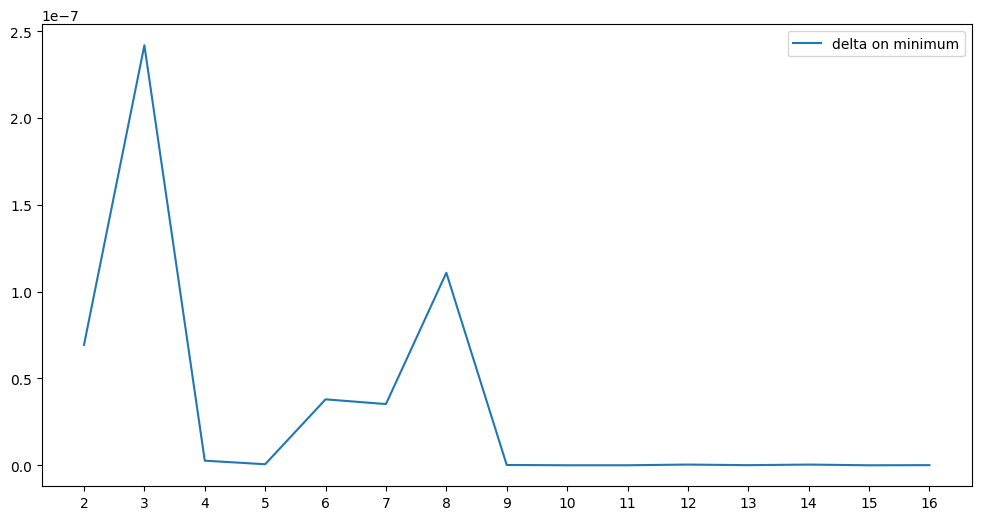

In [57]:

plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)

plt.plot(mean_res["delta_min_def"])
plt.legend(["delta on minimum"])
# mean_res.plot()

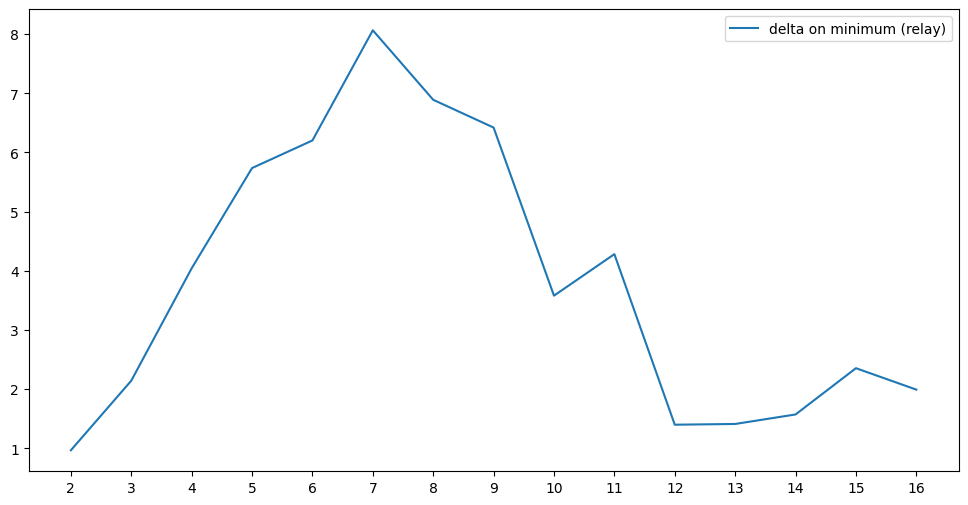

In [58]:

plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)

plt.plot(mean_res["delta_min_rel"])
plt.legend(["delta on minimum (relay)"])
# mean_res.plot()

1.7620599986833963e-06


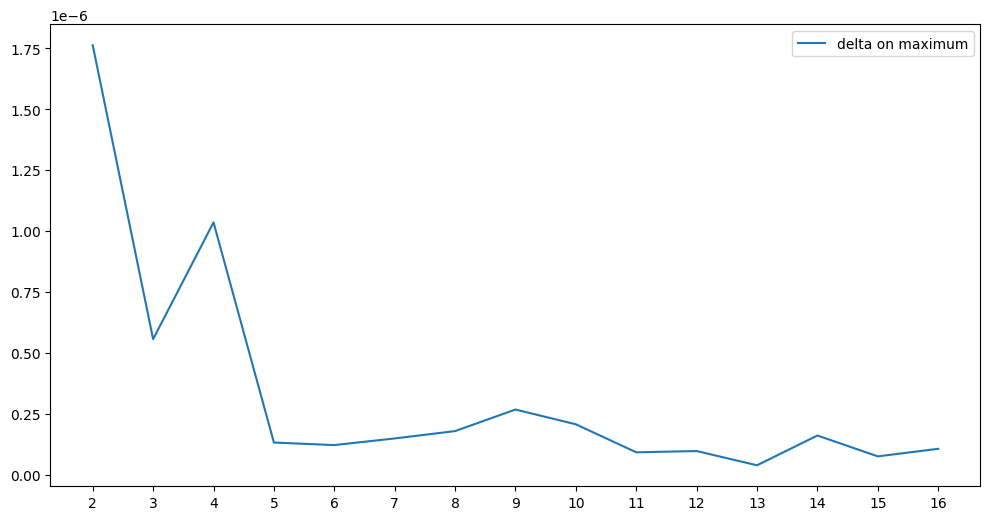

In [59]:
print(max(mean_res['delta_max']))
plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)
plt.plot(mean_res["delta_max"])
plt.legend(["delta on maximum"])

<Figure size 1200x600 with 0 Axes>

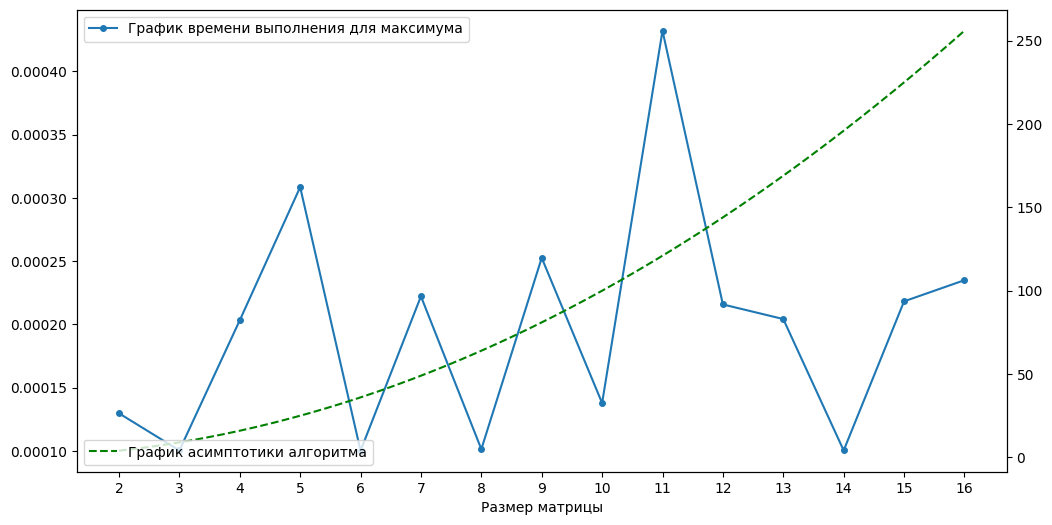

In [60]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_res['value_max_time'],  marker='o',  markersize=4, label='График времени выполнения для максимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 2, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()
# plt.xticks(ticks=x)
# plt.legend(["time for calculation of maximum"])


<Figure size 1200x600 with 0 Axes>

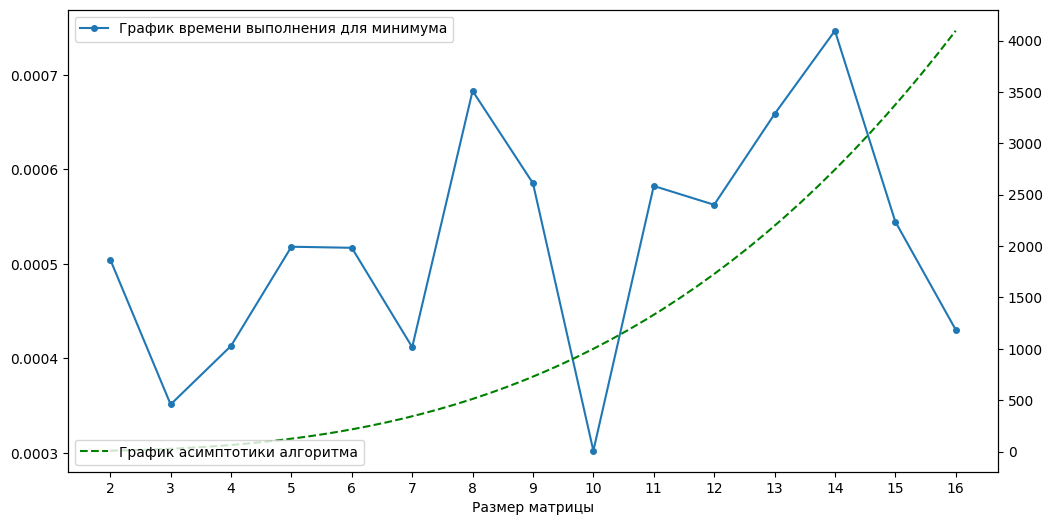

In [ ]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_res['value_min_def_time'],  marker='o',  markersize=4, label='График времени выполнения для минимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 3, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
# plt.plot(x=x, y=x**2)
# plt.legend(["time for calculation of minimum"])
plt.show()

In [62]:
# df.to_csv("data/df.csv")
# res_df.to_csv("data/res_df.csv")